In [1]:
from astropy.io import fits
from scipy.signal import fftconvolve
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={'figure.figsize': (20, 10)})
%matplotlib inline

In [3]:
simulation = "/scratch/datasets/astro_deconv_2019/"
clean_beams = "/scratch/datasets/astro_deconv_2019_cleanbeam_better/"
indexes=(5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000)

In [4]:
##landman
start = 9400
end = 9700

In [5]:
def open_fits(x):
    return fits.open(x)[0].data.squeeze()

def convolve(convoled, convolver):
    p = convolver.shape[0]
    r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
    return fftconvolve(convoled, convolver, mode="full")[r,r]

In [6]:
def compute(template, start=9400, end=9700):
    results = []
    for index in indexes:
        print(index)
        for number in range(start, end):
            neural_output = template.format(index=index)
            #if number in [9473, 1674, 4158]:
            #    continue
            target_path = "{}{}-skymodel.fits".format(simulation, number)
            neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
            clean_beam_path = "{}{}-clean-beam.fits".format(clean_beams, number)
            clean_beam = open_fits(clean_beam_path)
            target = open_fits(target_path)
            neural_model = open_fits(neural_model_path )
            target_convoled = convolve(target, clean_beam)
            neural_convolved = convolve(neural_model, clean_beam)
            score = np.sum(np.abs( neural_convolved - target_convoled))

            results.append((index, score))
    return df(results, columns=('index', 'score'))

In [7]:
half = compute("/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_half_dataset/{index}/fits/")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [8]:
full = compute("/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_verify/{index}/fits/")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [9]:
full_train = compute("/scratch/vacuum-cleaner/eval_train/astro_deconv_2019_res_gan_noscale/{index}/fits/", start=0, end=300)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [10]:
quarter = compute("/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_quarter_dataset/{index}/fits/")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [11]:
nopsf = compute("/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_nopsf/{index}/fits/")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [12]:
nopsf_l1 = compute("/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_nopsf_l1/{index}/fits/")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [13]:
#combined = df({'index': full['index'], 'full': full['score'], 'half': half['score'], 'quarter': quarter['score']})
combined = df({'index': full['index'], 'full_test': full['score'], 'half_test': half['score'], 'quarter_test': quarter['score'], 'full_train': full_train['score'], 'full_testnopsf_l1': nopsf_l1['score']})

In [16]:
combined.to_pickle('landman.pickle')

In [14]:
melted = combined.melt(id_vars=['index'])

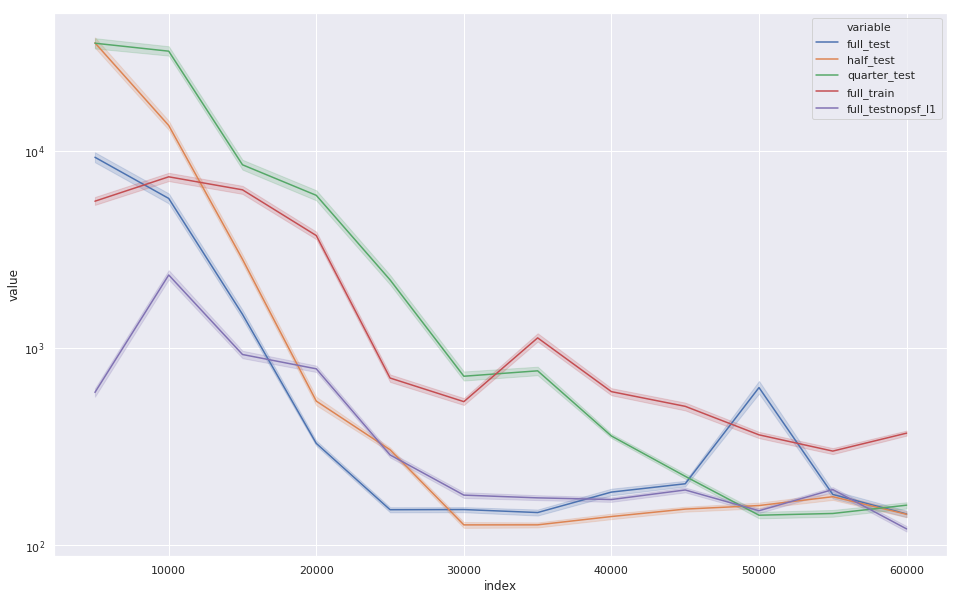

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set(yscale="log", xlabel='common xlabel', ylabel='common ylabel')
_ = sns.lineplot(data=melted, x='index', y='value', hue='variable', ax=ax)
plt.show()